**Q1) Do the visual encoders have the same architectures**
- No, CLIP does not use a single visual encoder architecture. Instead, it explores the use of both modified ResNet architectures (CNNs) and Vision Transformer architectures. These architectures differ fundamentally in their approach to processing visual information. ResNets rely on convolutional layers to extract features hierarchically, while ViTs treat an image as a sequence of patches and apply Transformer layers with self-attention mechanisms. The specific modifications made to the ResNet architecture within CLIP, such as the attention pooling, further distinguish it from a standard ResNet. The use of both types of architectures allows the CLIP model to leverage different strengths in visual representation learning.
- It is important to note that the text encoder used in CLIP is a Transformer architecture, distinct from both the ResNet and Vision Transformer-based visual encoders.The text encoder takes text as input, which is first converted into a lower-cased byte pair encoding (BPE) representation, and outputs a textual feature representation. These modality-specific feature representations are then linearly projected into a shared multi-modal embedding space where their similarity is calculated.

### Q2) ILSVRC: dataset setup
- ImageNet's label hierarchy is based on the WordNet hierarchy
- Each concept, mostly described by bunch of words, is called "synony set" is called "synset"

### Q3) Could grouping objects based on synsets lead to problems for visual recognition?
- Grouping objects based on synsets can lead to problems of visual recognition.
    - **Polysemy:** Without word context, models like CLIP would struggle to determine correct visual concepts. For example, ImageNet contains synsets for both construction cranes and birds that fly, both referred to as "cranes"
    - **Varying Granularity:** Levels of granularity used used in ImageNet may not be optimal for recognition task.
    
    - **Hierarchical Overlap:** For certain tasks, like the image classification task in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC), the 1000 selected synsets are chosen such that there is no hierarchical overlap between them (no synset is an ancestor of another within this subset). This suggests that directly using the full WordNet hierarchy, where broader synsets contain more specific ones, could lead to complications or ambiguities in classification tasks if not handled carefully.

### Q4) Visual differences in same synset
- **Variation in visual characterstics:** Objects within the same synset may exhibit differences in their appearancs due to factors such as style, material and colour or pose. e.g. visually similar synset like seals and seal otters mar come closer due to sysnset postulate.
- **Differences in image context and background:** Image captured in same synset mat be captured in different environmenta dna context.
 - **Changes in scale, viewpoint and articular:** Objects in the same synset may depict different scales, viewpoints and sate of articulation, etc.

---
---

In [16]:
! pip install tensorflow_datasets

  Preparing metadata (setup.py) ... done
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.6 MB/s eta 0:00:00a 0:00:01
Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21483 sha256=8a8b623bf60f8d941abb2db2fd824c86e252c3184fd88e6ed5ac16fa71d18d5a
  Stored in directory: /home/akash/.cache/pip/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
Successfully built promise
  Attempting uninstall: absl-py
    Found existing installation: absl-py 2.1.0
    Uninstalling absl-py-2.1.0:
      Successfully uninstalled absl-py-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.1 requires numpy<=1.24.3,>=1.22,

In [104]:
from torchvision import datasets, transforms

from torchvision.datasets import ImageNet
import torchvision.transforms as T
import torch
import clip
from PIL import Image
from torch.utils.data import DataLoader


In [105]:


class CLIPClassifier:
    def __init__(self, imagenet_classes, model_type="transformer"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.imagenet_classes = imagenet_classes
        self.text_inputs = torch.cat([
            clip.tokenize(f"a photo of a {c}") for c in imagenet_classes
        ]).to(self.device)
        if model_type == "transformer":
            self.model, self.preprocess = clip.load("ViT-B/32", self.device)
        elif model_type == "rn50":
            self.model, self.preprocess = clip.load("RN50", self.device)
        else:
            raise ValueError("model_type must be 'transformer' or 'rn50'")
        self.model_type = model_type
    
    def classify_image(self, image_path):
        image = self.preprocess(Image.open(image_path)).unsqueeze(0).to(self.device)
        with torch.no_grad():
            image_features = self.model.encode_image(image)
            text_features = self.model.encode_text(self.text_inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logit_scale = self.model.logit_scale.exp()
        logits = logit_scale * (image_features @ text_features.T)
        probs = logits.softmax(dim=-1)
        return probs.detach().cpu().numpy()




In [106]:
imagenet_classes10 = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", 
                    "garbage truck", "gas pump", "golf ball", "parachute"]

In [107]:
def load_txt_to_list(filename):
    with open(filename, 'r') as file:
        lines = [line.strip() for line in file]
    return lines

imagenet_classes = load_txt_to_list("/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/imagenet_classes.txt")
len(imagenet_classes)

1000

In [108]:

vit_classifier = CLIPClassifier(imagenet_classes, model_type="transformer")
rn50_classifier = CLIPClassifier(imagenet_classes, model_type="rn50")

In [109]:
image_path = "/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n03425413/ILSVRC2012_val_00005183.JPEG"
# Get top predictions
probs = vit_classifier.classify_image(image_path)
top_indices = probs.argsort()[0][-5:][::-1]

print("Top 5 predictions:")
for idx in top_indices:
    print(f"{imagenet_classes[idx]:<25} {probs[0][idx]*100:.2f}%")

print("==="*10)
probs = rn50_classifier.classify_image(image_path)
top_indices = probs.argsort()[0][-5:][::-1]

print("Top 5 predictions:")
for idx in top_indices:
    print(f"{imagenet_classes[idx]:<25} {probs[0][idx]*100:.2f}%")

Top 5 predictions:
cash machine              25.34%
pay-phone                 24.94%
vending machine           17.97%
gas pump                  9.18%
refrigerator              4.01%
Top 5 predictions:
pay-phone                 67.77%
cellular telephone        10.24%
dial telephone            3.82%
radio                     2.80%
vending machine           1.59%


### CLIP better than RN50

In [110]:
image_path = "/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n03425413/ILSVRC2012_val_00005183.JPEG"

# image_path = "/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/val/n03394916/n03394916_29142.JPEG"

![exp1](/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n03425413/ILSVRC2012_val_00005183.JPEG)

With 1000 classes, many categories are conceptually similar, making it much harder for the **text encoder** to distinguish them. With 10 classes the chance of classes being simantically similar is lower and model csn seperate out those with ease. As CLIP matches an image embedding to text embedding, with 1000 classes its symatically close texts embedding beocme prominent and probabilitygot distributed among those. But, with smaller classes, chances of text being symantically closes are less making model predictions more sharper.

#### ImageNet 10 classes

In [111]:
vit_classifier10 = CLIPClassifier(imagenet_classes10, model_type="transformer")
rn50_classifier10 = CLIPClassifier(imagenet_classes10, model_type="rn50")

In [112]:
# Get top predictions
probs = vit_classifier10.classify_image(image_path)
top_indices = probs.argsort()[0][-5:][::-1]
print("Top 5 predictions:")
for idx in top_indices:
    print(f"{imagenet_classes10[idx]:<25} {probs[0][idx]*100:.2f}%")

print("==="*10)
probs = rn50_classifier10.classify_image(image_path)
top_indices = probs.argsort()[0][-5:][::-1]

print("Top 5 predictions:")
for idx in top_indices:
    print(f"{imagenet_classes10[idx]:<25} {probs[0][idx]*100:.2f}%")


Top 5 predictions:
gas pump                  98.54%
cassette player           1.03%
garbage truck             0.40%
church                    0.03%
French horn               0.01%
Top 5 predictions:
gas pump                  76.66%
cassette player           22.67%
garbage truck             0.33%
church                    0.21%
chain saw                 0.06%


#### Why ResNet is not performing well?

- resnet is trained on ~1.4 Million dataset while CLIP trained on 400+ million, making it more orbust to zero-shot as compared to resnet.
- "gas pump" class is top 1% class of image-net trained resnet50 having 70-80% accuracy on that class.
- CLIP works on supervisory signal of text embedding as compared to only image feature in resnet making CLIP more confident on its prediction.
CLIP’s transformer-based architecture can capture long-range dependencies and global context better than ResNet50’s convolutional layers, which focus on local features. In the above image the gas pump somehow resembles with background, making it harder for CNN based RN50 to seperate out background and foreground.

- Got the image from ImageNet itself

### ResNet50 better performer

In [113]:
###Image path
image_path = "/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n02979186/ILSVRC2012_val_00005866.JPEG"

probs = vit_classifier10.classify_image(image_path)
top_indices = probs.argsort()[0][-5:][::-1]
print("Top 5 predictions:")
for idx in top_indices:
    print(f"{imagenet_classes10[idx]:<25} {probs[0][idx]*100:.2f}%")

print("==="*10)
probs = rn50_classifier10.classify_image(image_path)
top_indices = probs.argsort()[0][-5:][::-1]

print("Top 5 predictions:")
for idx in top_indices:
    print(f"{imagenet_classes10[idx]:<25} {probs[0][idx]*100:.2f}%")


Top 5 predictions:
French horn               49.68%
cassette player           41.19%
parachute                 2.98%
chain saw                 2.94%
golf ball                 2.05%
Top 5 predictions:
cassette player           97.17%
golf ball                 2.67%
French horn               0.10%
chain saw                 0.04%
garbage truck             0.02%


The image looks very similar to french horn, as a generalised model both French horn and cassette player is sharing the 49% and 41% accuracy, making it hard for CLIP to distingusing.

But as a specialised model on this class, Resnet makes it better classification.

### FP16

In [157]:
import torch
from PIL import Image
import clip
import time

class CLIPClassifierFP16:
    def __init__(self, imagenet_classes, model_type="transformer"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.imagenet_classes = imagenet_classes
        # Tokenize text prompts
        self.text_inputs = torch.cat([
            clip.tokenize(f"a photo of a {c}") for c in imagenet_classes
        ]).to(self.device)
        # Load model
        if model_type == "transformer":
            self.model, self.preprocess = clip.load("ViT-B/32", self.device)
        elif model_type == "rn50":
            self.model, self.preprocess = clip.load("RN50", self.device)
        else:
            raise ValueError("model_type must be 'transformer' or 'rn50'")
        # Convert model to FP16
        self.model.half()
        assert self.model.dtype == torch.half , "model is of fp16"

    def classify_image(self, image_path):
        # Preprocess image and convert to FP16
        image = self.preprocess(Image.open(image_path)).unsqueeze(0).to(self.device).half()
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                image_features = self.model.encode_image(image)
                text_features = self.model.encode_text(self.text_inputs)
            # image_features = self.model.encode_image(image)
            # text_features = self.model.encode_text(self.text_inputs).to(image_features.dtype)
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        # Compute logits
        logit_scale = self.model.logit_scale.exp()
        logits = logit_scale * (image_features @ text_features.T)
        probs = logits.softmax(dim=-1)
        return probs.detach().cpu().numpy()




In [158]:
vit_classifier = CLIPClassifier(imagenet_classes10, model_type="transformer")
rn50_classifier = CLIPClassifier(imagenet_classes10, model_type="rn50")


vit_classifier16 = CLIPClassifierFP16(imagenet_classes10, model_type="transformer")
rn50_classifier16 = CLIPClassifierFP16(imagenet_classes10, model_type="rn50")

In [159]:
# dataser ready

import os

def get_image_files(root_dir, extensions=None):
    
    if extensions is None:
        extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}

    image_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            ext = os.path.splitext(filename)[1].lower()
            if ext in extensions:
                full_path = os.path.join(dirpath, filename)
                image_files.append(full_path)
                break
    return image_files

if __name__ =="__main__":
    image_files_per_class = get_image_files("/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train")
    print(image_files_per_class)

['/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n02102040/n02102040_6256.JPEG', '/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n02979186/n02979186_23309.JPEG', '/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n03394916/n03394916_11754.JPEG', '/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n03445777/n03445777_278.JPEG', '/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n03425413/n03425413_21166.JPEG', '/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n01440764/n01440764_1313.JPEG', '/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n03000684/n03000684_11113.JPEG', '/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n03888257/n03888257_27333.JPEG', '/h

### Ccalulate probability distribution:

In [160]:
import pandas as pd




def create_prediction_df(image_paths, clip_model, clip_model16, class_names):
    results = []
    
    for img_path in image_paths:
        # Get predictions from both models
        clip_probs = clip_model.classify_image(img_path)[0]
        resnet_probs = clip_model16.classify_image(img_path)[0]
        
        # Process CLIP predictions
        clip_top_indices = clip_probs.argsort()[-5:][::-1]
        clip_preds = {}
        for rank, idx in enumerate(clip_top_indices, 1):
            clip_preds[f"top{rank}_class"] = class_names[idx]
            clip_preds[f"top{rank}_prob"] = clip_probs[idx].item() * 100
        
        results.append({
            "image_path": img_path,
            "model_type": "CLIP",
            **clip_preds
        })
        
        # Process ResNet predictions
        resnet_top_indices = resnet_probs.argsort()[-5:][::-1]
        resnet_preds = {}
        for rank, idx in enumerate(resnet_top_indices, 1):
            resnet_preds[f"top{rank}_class"] = class_names[idx]
            resnet_preds[f"top{rank}_prob"] = resnet_probs[idx].item() * 100
        
        results.append({
            "image_path": img_path,
            "model_type": "CLIP16",
            **resnet_preds
        })
    
    return pd.DataFrame(results)

# Usage example
df = create_prediction_df(
    image_paths=image_files_per_class,
    clip_model=vit_classifier,
    clip_model16=vit_classifier16,
    class_names=imagenet_classes
)
df

/tmp/ipykernel_3218607/1867533366.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


,image_path,model_type,top1_class,top1_prob,top2_class,top2_prob,top3_class,top3_prob,top4_class,top4_prob,top5_class,top5_prob
0,/home/akash/ws/cv_assignment/assignment-5-MlLe...,CLIP,goldfish,100.000000,cock,0.000662,ostrich,0.000578,tiger shark,0.000560,hen,0.000387
1,/home/akash/ws/cv_assignment/assignment-5-MlLe...,CLIP16,goldfish,100.000000,cock,0.000674,ostrich,0.000578,tiger shark,0.000566,hen,0.000381
2,/home/akash/ws/cv_assignment/assignment-5-MlLe...,CLIP,great white shark,99.658203,cock,0.118542,ostrich,0.070810,electric ray,0.055981,hen,0.030446
3,/home/akash/ws/cv_assignment/assignment-5-MlLe...,CLIP16,great white shark,99.658203,cock,0.118542,ostrich,0.070810,electric ray,0.056887,hen,0.030923
4,/home/akash/ws/cv_assignment/assignment-5-MlLe...,CLIP,electric ray,100.000000,ostrich,0.000066,hammerhead,0.000006,tiger shark,0.000006,hen,0.000000
5,/home/akash/ws/cv_assignment/assignment-5-MlLe...,CLIP16,electric ray,100.000000,ostrich,0.000066,hammerhead,0.000006,tiger shark,0.000006,hen,0.000000
6,/home/akash/ws/cv_assignment/assignment-5-MlLe...,CLIP,hen,100.000000,ostrich,0.008219,goldfish,0.001919,tiger shark,0.000495,stingray,0.000244
7,/home/akash/ws/cv_assignment/assignment-5-MlLe...,CLIP16,hen,100.000000,ostrich,0.008219,goldfish,0.001889,tiger shark,0.000495,stingray,0.000238
8,/home/akash/ws/cv_assignment/assignment-5-MlLe...,CLIP,cock,100.000000,great white shark,0.000995,stingray,0.000709,electric ray,0.000137,tiger shark,0.000054
9,/home/akash/ws/cv_assignment/assignment-5-MlLe...,CLIP16,cock,100.000000,great white shark,0.000995,stingray,0.000709,electric ray,0.000143,tiger shark,0.000054


- Don't see any difference

### Benchmarking

/tmp/ipykernel_3218607/302059753.py:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler(enabled=self.use_fp16)
100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


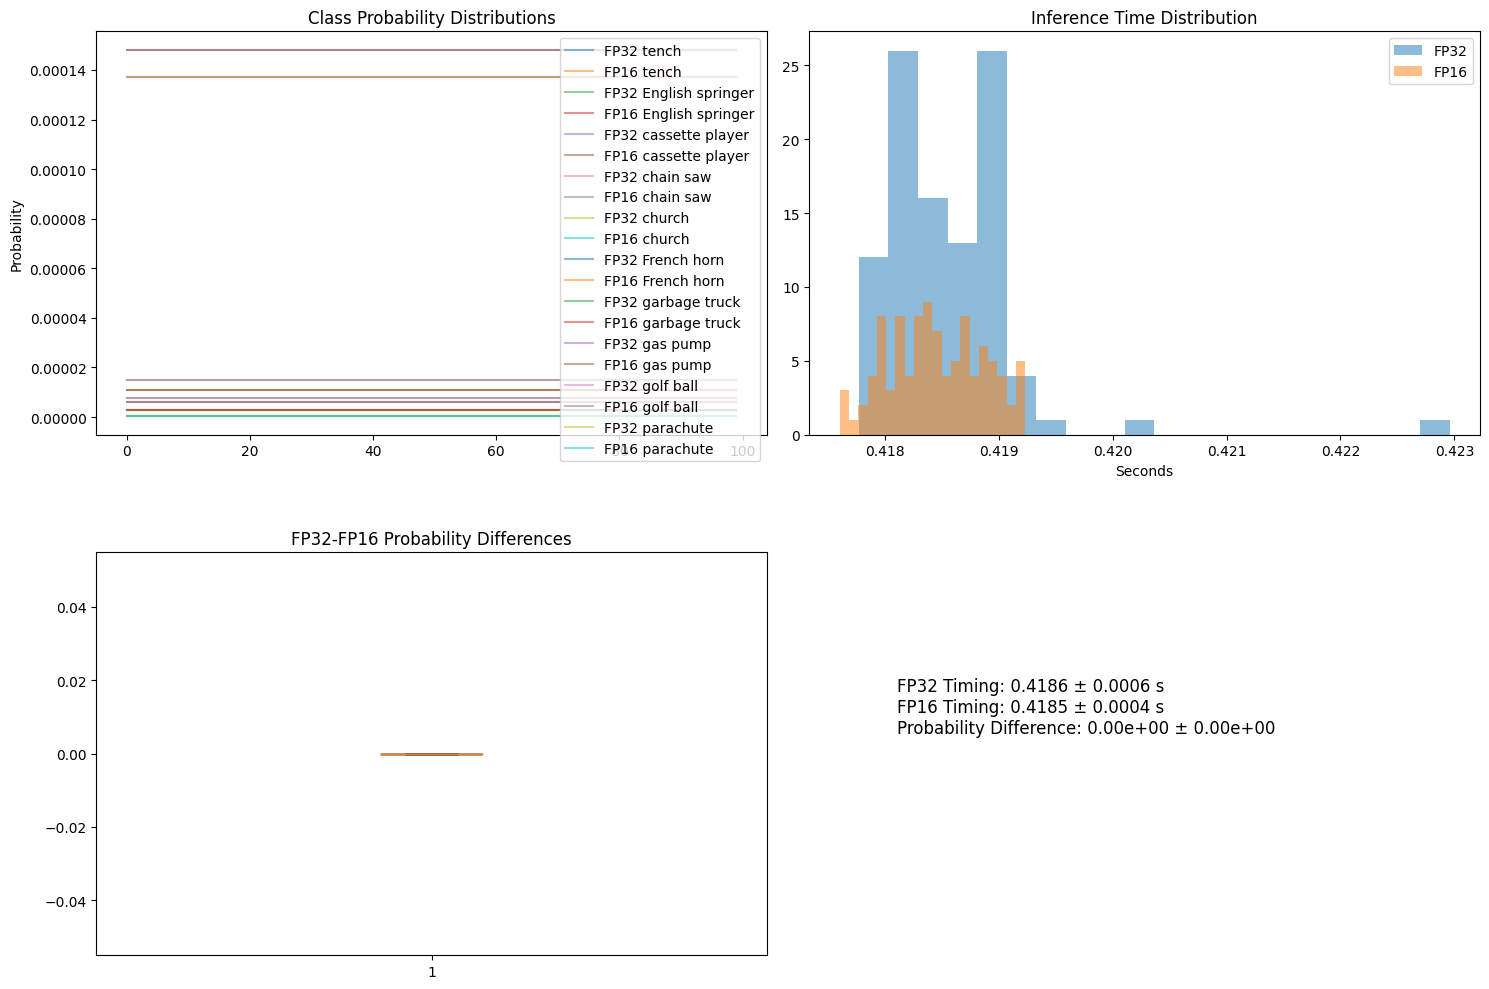

In [156]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def benchmark_models(image_path, num_runs=100):
    # Initialize models
    clip_fp32 = CLIPClassifier(imagenet_classes, "transformer")
    clip_fp16 = CLIPClassifierFP16(imagenet_classes, "transformer")
    
    # Storage for results
    results = {
        'fp32_probs': [],
        'fp16_probs': [],
        'fp32_times': [],
        'fp16_times': []
    }
    
    # Preprocess image once
    image = Image.open(image_path)
    
    for _ in tqdm(range(num_runs)):
        # FP32 Benchmark
        start = time.perf_counter()
        fp32_probs = clip_fp32.classify_image(image_path)
        results['fp32_times'].append(time.perf_counter() - start)
        results['fp32_probs'].append(fp32_probs[0])
        
        # FP16 Benchmark
        start = time.perf_counter()
        fp16_probs = clip_fp16.classify_image(image_path)
        results['fp16_times'].append(time.perf_counter() - start)
        results['fp16_probs'].append(fp16_probs[0])
    
    return results

def analyze_results(results, class_names):
    # Convert to numpy arrays
    fp32_probs = np.array(results['fp32_probs'])
    fp16_probs = np.array(results['fp16_probs'])
    
    # Probability difference analysis
    prob_diff = fp32_probs - fp16_probs
    diff_stats = {
        'mean_diff': np.mean(prob_diff),
        'std_diff': np.std(prob_diff),
        'max_diff': np.max(prob_diff),
        'min_diff': np.min(prob_diff)
    }
    
    # Timing analysis
    time_stats = {
        'fp32_mean': np.mean(results['fp32_times']),
        'fp32_std': np.std(results['fp32_times']),
        'fp16_mean': np.mean(results['fp16_times']),
        'fp16_std': np.std(results['fp16_times'])
    }
    
    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Probability distributions
    for i, class_name in enumerate(class_names):
        axs[0,0].plot(fp32_probs[:, i], alpha=0.5, label=f'FP32 {class_name}')
        axs[0,0].plot(fp16_probs[:, i], alpha=0.5, label=f'FP16 {class_name}')
    axs[0,0].set_title('Class Probability Distributions')
    axs[0,0].set_ylabel('Probability')
    axs[0,0].legend()
    
    # Timing distributions
    axs[0,1].hist(results['fp32_times'], bins=20, alpha=0.5, label='FP32')
    axs[0,1].hist(results['fp16_times'], bins=20, alpha=0.5, label='FP16')
    axs[0,1].set_title('Inference Time Distribution')
    axs[0,1].set_xlabel('Seconds')
    axs[0,1].legend()
    
    # Probability differences
    axs[1,0].boxplot(prob_diff.flatten())
    axs[1,0].set_title('FP32-FP16 Probability Differences')
    
    # Statistical summary
    stats_text = f"""
    FP32 Timing: {time_stats['fp32_mean']:.4f} ± {time_stats['fp32_std']:.4f} s
    FP16 Timing: {time_stats['fp16_mean']:.4f} ± {time_stats['fp16_std']:.4f} s
    Probability Difference: {diff_stats['mean_diff']:.2e} ± {diff_stats['std_diff']:.2e}
    """
    axs[1,1].text(0.1, 0.5, stats_text, fontsize=12)
    axs[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return diff_stats, time_stats

# Usage
image_path = "/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n02979186/ILSVRC2012_val_00005866.JPEG"
results = benchmark_models(image_path, num_runs=100)
diff_stats, time_stats = analyze_results(results, imagenet_classes10)

---
---

In [50]:
# Get top predictions
probs = vit_classifier16.classify_image(image_path)
top_indices = probs.argsort()[0][-5:][::-1]

print("Top 5 predictions:")
for idx in top_indices:
    print(f"{imagenet_classes[idx]:<25} {probs[0][idx]*100:.2f}%")

print("="*10)
probs = rn50_classifier16.classify_image(image_path)
top_indices = probs.argsort()[0][-5:][::-1]

print("Top 5 predictions:")
for idx in top_indices:
    print(f"{imagenet_classes[idx]:<25} {probs[0][idx]*100:.2f}%")


Top 5 predictions:
electric ray              49.32%
great white shark         41.53%
ostrich                   2.96%
tiger shark               2.96%
hen                       2.07%
Top 5 predictions:
great white shark         96.97%
hen                       2.84%
electric ray              0.10%
tiger shark               0.04%
stingray                  0.02%


/tmp/ipykernel_3218607/3126136429.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Benchmarking FP32 vs FP16:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3218607/538616464.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Benchmarking FP32 vs FP16: 100%|██████████| 100/100 [00:01<00:00, 69.21it/s]


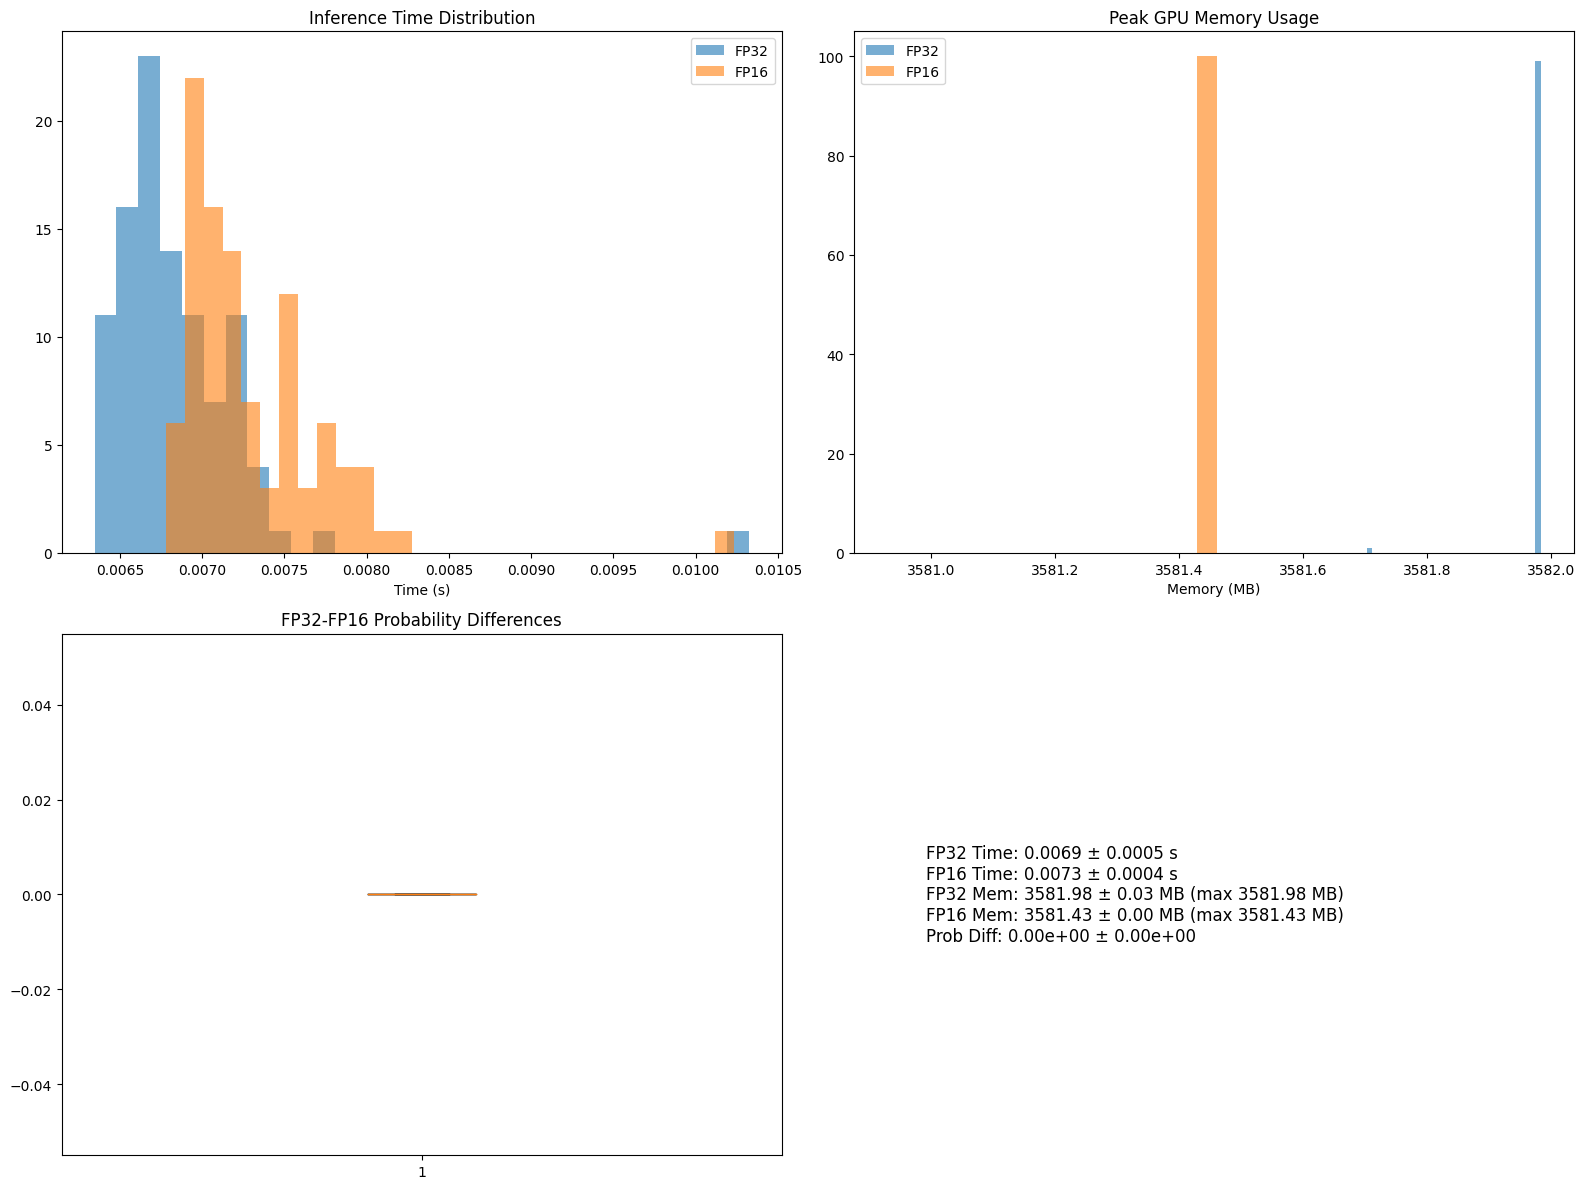

Difference Stats: {'mean_diff': 0.0, 'std_diff': 0.0, 'max_diff': 0.0, 'min_diff': 0.0}
Timing Stats: {'fp32_mean': 0.006850747861899435, 'fp32_std': 0.000450871891144951, 'fp16_mean': 0.007307473816908896, 'fp16_std': 0.0004463364846447461}
Memory Stats (MB): {'fp32_mean_mb': 3581.98107421875, 'fp32_std_mb': 0.027984021668623692, 'fp16_mean_mb': 3581.42822265625, 'fp16_std_mb': 0.0, 'fp32_max_mb': 3581.98388671875, 'fp16_max_mb': 3581.42822265625}


In [80]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Ensure GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def benchmark_models(image_path, model_classes, num_runs=100):
    """
    Benchmarks FP32 vs FP16 inference time and peak GPU memory usage.

    Args:
        image_path (str): Path to input image.
        model_classes (List[str]): List of class names for classification.
        num_runs (int): Number of runs to average over.

    Returns:
        dict: Contains lists for times, probabilities, and memory usage for each precision.
    """
    # Initialize models on GPU
    clip_fp32 = CLIPClassifier(model_classes, "transformer")#.to(device).eval()
    clip_fp16 = CLIPClassifierFP16(model_classes, "transformer")#.to(device).eval()

    # Storage for results
    results = {
        'fp32_probs': [],
        'fp16_probs': [],
        'fp32_times': [],
        'fp16_times': [],
        'fp32_mem_mb': [],
        'fp16_mem_mb': []
    }

    # Pre-load and preprocess image once
    image = Image.open(image_path)

    for _ in tqdm(range(num_runs), desc="Benchmarking FP32 vs FP16"):
        # FP32 Benchmark
        torch.cuda.reset_peak_memory_stats(device)
        start = time.perf_counter()
        with torch.no_grad():
            probs32 = clip_fp32.classify_image(image_path)
        elapsed32 = time.perf_counter() - start
        peak32 = torch.cuda.max_memory_allocated(device) / (1024**2)  # MB
        results['fp32_times'].append(elapsed32)
        results['fp32_probs'].append(probs32[0])
        results['fp32_mem_mb'].append(peak32)

        # FP16 Benchmark
        torch.cuda.reset_peak_memory_stats(device)
        start = time.perf_counter()
        with torch.no_grad():
            probs16 = clip_fp16.classify_image(image_path)
        elapsed16 = time.perf_counter() - start
        peak16 = torch.cuda.max_memory_allocated(device) / (1024**2)  # MB
        results['fp16_times'].append(elapsed16)
        results['fp16_probs'].append(probs16[0])
        results['fp16_mem_mb'].append(peak16)

    return results


def analyze_results(results, class_names):
    """
    Analyzes timing, probability, and GPU memory usage results.
    Generates plots for inference time, probability differences, and memory.
    """
    # Convert to numpy
    fp32_probs = np.array(results['fp32_probs'])
    fp16_probs = np.array(results['fp16_probs'])
    fp32_mem = np.array(results['fp32_mem_mb'])
    fp16_mem = np.array(results['fp16_mem_mb'])

    # Probability differences
    prob_diff = fp32_probs - fp16_probs
    diff_stats = {
        'mean_diff': np.mean(prob_diff),
        'std_diff': np.std(prob_diff),
        'max_diff': np.max(prob_diff),
        'min_diff': np.min(prob_diff)
    }

    # Timing stats
    time_stats = {
        'fp32_mean': np.mean(results['fp32_times']),
        'fp32_std': np.std(results['fp32_times']),
        'fp16_mean': np.mean(results['fp16_times']),
        'fp16_std': np.std(results['fp16_times'])
    }

    # Memory stats
    mem_stats = {
        'fp32_mean_mb': np.mean(fp32_mem),
        'fp32_std_mb': np.std(fp32_mem),
        'fp16_mean_mb': np.mean(fp16_mem),
        'fp16_std_mb': np.std(fp16_mem),
        'fp32_max_mb': np.max(fp32_mem),
        'fp16_max_mb': np.max(fp16_mem)
    }

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # Inference time histogram
    axs[0, 0].hist(results['fp32_times'], bins=30, alpha=0.6, label='FP32')
    axs[0, 0].hist(results['fp16_times'], bins=30, alpha=0.6, label='FP16')
    axs[0, 0].set_title('Inference Time Distribution')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].legend()

    # Memory usage histogram
    axs[0, 1].hist(fp32_mem, bins=30, alpha=0.6, label='FP32')
    axs[0, 1].hist(fp16_mem, bins=30, alpha=0.6, label='FP16')
    axs[0, 1].set_title('Peak GPU Memory Usage')
    axs[0, 1].set_xlabel('Memory (MB)')
    axs[0, 1].legend()

    # Probability differences boxplot
    axs[1, 0].boxplot(prob_diff.flatten())
    axs[1, 0].set_title('FP32-FP16 Probability Differences')

    # Summary text
    summary = (
        f"FP32 Time: {time_stats['fp32_mean']:.4f} ± {time_stats['fp32_std']:.4f} s\n"
        f"FP16 Time: {time_stats['fp16_mean']:.4f} ± {time_stats['fp16_std']:.4f} s\n"
        f"FP32 Mem: {mem_stats['fp32_mean_mb']:.2f} ± {mem_stats['fp32_std_mb']:.2f} MB (max {mem_stats['fp32_max_mb']:.2f} MB)\n"
        f"FP16 Mem: {mem_stats['fp16_mean_mb']:.2f} ± {mem_stats['fp16_std_mb']:.2f} MB (max {mem_stats['fp16_max_mb']:.2f} MB)\n"
        f"Prob Diff: {diff_stats['mean_diff']:.2e} ± {diff_stats['std_diff']:.2e}"
    )
    axs[1, 1].text(0.1, 0.5, summary, fontsize=12, va='center')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    return diff_stats, time_stats, mem_stats


if __name__ == '__main__':
    image_path = '/home/akash/ws/cv_assignment/assignment-5-MlLearnerAkash/Q3/ImageNetData/imagenette2/train/n02979186/ILSVRC2012_val_00005866.JPEG'
    # Replace with your 10 class names
    imagenet_classes10 = [...] 

    # Run benchmark
    results = benchmark_models(image_path, imagenet_classes10, num_runs=100)
    diff_stats, time_stats, mem_stats = analyze_results(results, imagenet_classes10)

    # Additional: Use nvidia-smi for cross-check
    # Run in shell: !nvidia-smi --query-gpu=memory.used --format=csv -l 1
    # Capture screenshots to include in your report

    # Print final stats for report
    print('Difference Stats:', diff_stats)
    print('Timing Stats:', time_stats)
    print('Memory Stats (MB):', mem_stats)
